In [379]:
import pandas as pd
from database.adatabase import ADatabase
from xgboost import XGBRegressor
import matplotlib.pyplot as plt
from tqdm import tqdm
from processor.processor import Processor as p
from asset.exposure import Exposure
from equations.capm import CAPM
from sklearn.preprocessing import normalize
import yfinance as yf

In [380]:
sec = ADatabase("sec")
market = ADatabase("market")
fred = ADatabase("fred")

In [381]:
market.connect()
index = market.retrieve("sp500")
market.disconnect()
factors = ["assets","liabilities","reference_price"]
fred.connect()
sp500 = p.column_date_processing(fred.retrieve("sp500_projections").rename(columns={"prediction":"sp500_prediction"}))
interest_rates = p.column_date_processing(fred.retrieve("market_yield").rename(columns={"value":"rf"}))
interest_rates["rf"] = interest_rates["rf"].replace(".",0)
interest_rates["rf"] = [float(x) / 100 for x in interest_rates["rf"]]
fred.disconnect
macro = sp500.merge(interest_rates,on="date",how="left")

In [413]:
macro["sp500_prediction"] = macro["sp500"] * 1.1 ** (1/265)
macro

,date,sp500,sp500_prediction,realtime_start,realtime_end,rf
0,2019-01-02,2510.03,2510.932922,2024-10-13,2024-10-13,0.0266
1,2019-01-03,2447.89,2448.770569,2024-10-13,2024-10-13,0.0256
2,2019-01-04,2531.94,2532.850804,2024-10-13,2024-10-13,0.0267
3,2019-01-07,2549.69,2550.607189,2024-10-13,2024-10-13,0.0270
4,2019-01-08,2574.41,2575.336082,2024-10-13,2024-10-13,0.0273
...,...,...,...,...,...,...
1450,2024-10-07,5695.94,5697.988976,2024-10-13,2024-10-13,0.0403
1451,2024-10-08,5751.13,5753.198830,2024-10-13,2024-10-13,0.0404
1452,2024-10-09,5792.04,5794.123546,2024-10-13,2024-10-13,0.0406
1453,2024-10-10,5780.05,5782.129233,2024-10-13,2024-10-13,0.0409


In [382]:
market_caps = {}
for ticker in tqdm(index["ticker"]):
    try:
        stock_info = yf.Ticker(ticker).info
        market_caps[ticker] = stock_info['marketCap']
    except KeyError:
        market_caps[ticker] = None  # Handle missing data

# Convert to DataFrame
market_caps_df = pd.DataFrame(list(market_caps.items()), columns=['ticker', 'market_cap'])

print(market_caps_df)

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 502/502 [01:46<00:00,  4.71it/s]

    ticker    market_cap
0      MMM  7.087980e+10
1      AOS  9.937958e+09
2      ABT  1.993155e+11
3     ABBV  3.144449e+11
4      ACN  2.226834e+11
..     ...           ...
497    XYL  2.861399e+10
498    YUM  3.769426e+10
499   ZBRA  2.014637e+10
500    ZBH  2.130092e+10
501    ZTS  7.419408e+10

[502 rows x 2 columns]


In [383]:
market.connect()
sec.connect()
factors_df = []
for row in tqdm(index.iterrows()):
    try:
        ticker = row[1]["ticker"]
        cik = int(row[1]["CIK"])
        price = p.column_date_processing(market.query("prices",{"ticker":ticker}))
        price.sort_values("date")
        price["year"] = [x.year for x in price["date"]]
        price["quarter"] = [x.quarter for x in price["date"]]
        filings = p.column_date_processing(sec.query("filings",{"cik":cik}))
        # filings["year"] = [x.year + 1 for x in filings["date"]]
        # filings["quarter"] = [x.quarter for x in filings["date"]]
        filings["year"] = [x.year if x.quarter < 4 else x.year + 1 for x in filings["date"]]
        filings["quarter"] = [x.quarter + 1 if x.quarter < 4 else 1 for x in filings["date"]]
        ticker_factors = filings.drop(["date","cik"],axis=1).groupby(["year","quarter"]).mean().reset_index()
        price = price.drop(["date","ticker"],axis=1).groupby(["year","quarter"]).mean().reset_index()
        ticker_factors = ticker_factors.merge(price,on=["year","quarter"],how="left")
        ticker_factors["ticker"] = ticker
        ticker_factors["reference_price"] = ticker_factors["adjclose"].shift(1)
        ticker_factors["y"] = ticker_factors["adjclose"].shift(-1)
        factors_df.append(ticker_factors[["year","quarter","ticker","adjclose","y"]+factors])
    except Exception as e:
        print(ticker,str(e))
        continue
sec.disconnect()
market.disconnect()
factors_df = pd.concat(factors_df).sort_values(["year","quarter"])

26it [00:01, 18.46it/s]

AMTM 'date'


63it [00:04, 17.05it/s]

BRK.B 'date'


67it [00:04, 15.96it/s]

BLK 'date'


78it [00:05, 17.05it/s]

BF.B 'date'


502it [00:34, 14.70it/s]

ZTS 'date'


In [384]:
factors_df.sort_values(["ticker","year","quarter"])

,year,quarter,ticker,adjclose,y,assets,liabilities,reference_price
0,2013,2,A,28.453485,30.957480,1.059450e+10,5.326500e+09,NaN
1,2013,3,A,30.957480,34.982295,1.056150e+10,5.315000e+09,28.453485
2,2013,4,A,34.982295,37.984034,1.040700e+10,5.419500e+09,30.957480
3,2014,1,A,37.984034,37.120989,1.061100e+10,5.374000e+09,34.982295
4,2014,2,A,37.120989,37.846924,1.066200e+10,5.294000e+09,37.984034
...,...,...,...,...,...,...,...,...
42,2023,4,ZBRA,228.265714,267.628852,7.492500e+09,4.630000e+09,271.507302
43,2024,1,ZBRA,267.628852,304.088016,7.430000e+09,4.557000e+09,228.265714
44,2024,2,ZBRA,304.088016,335.879531,7.417500e+09,4.533000e+09,267.628852
45,2024,3,ZBRA,335.879531,387.112069,7.282500e+09,4.180000e+09,304.088016


In [385]:
model = XGBRegressor()
factors_df = factors_df.dropna(subset=factors)
training_data = factors_df[(factors_df["year"]>=2015) & (factors_df["year"]<2022)].dropna()
sim = factors_df[(factors_df["year"]>=2021)].dropna(subset=factors)
model.fit(training_data[factors],training_data["y"])
sim["prediction"] = model.predict(sim[factors])
sim = sim[["year","quarter","ticker","prediction"]]

In [414]:
market.connect()
prices = []
for ticker in tqdm(index["ticker"]):
    try:
        price = p.column_date_processing(market.query("prices",{"ticker":ticker}))
        price.sort_values("date",inplace=True)
        price["year"] = [x.year for x in price["date"]]
        price["quarter"] = [x.quarter for x in price["date"]]
        price.sort_values("date",inplace=True)
        price = price.merge(sim[["year","quarter","ticker","prediction"]],on=["year","quarter","ticker"],how="left").merge(macro,on="date",how="left")
        price["factor"] = price["prediction"] / price["adjclose"] - 1
        price = CAPM.apply(price)
        prices.append(price)
    except Exception as e:
        print(str(e))
        continue
market.disconnect()

 13%|███████████████████▏                                                                                                                                     | 63/502 [00:03<00:23, 18.33it/s]

'date'


 16%|███████████████████████▊                                                                                                                                 | 78/502 [00:04<00:23, 18.16it/s]

'date'


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 502/502 [00:31<00:00, 15.97it/s]

'date'


In [415]:
simulation = pd.concat(prices).merge(index,on="ticker",how="left").merge(market_caps_df,on="ticker",how="left")
simulation["year"] = simulation["date"].dt.year
simulation["quarter"] = simulation["date"].dt.quarter
simulation = simulation[(simulation["year"]>=2022)].dropna()
tickers = list(simulation[simulation["year"]==2022]["ticker"].unique())
simulation = simulation[simulation["ticker"].isin(tickers)]
simulation["rank"] = simulation.groupby(["date","GICS Sector"])["factor"].rank(method="dense",ascending=False).astype(int)
simulation["exposure"] = [1 if x <= simulation["rank"].max() * 0.50 else -1 if x > simulation["rank"].max() * 0.50 else 1.0/6.0 for x in simulation["rank"]]
simulation["sell_price"] = simulation["adjclose"]
simulation["sell_date"] = simulation["date"]
simulation.sort_values("date",inplace=True)

In [416]:
def rank_list(value,i):
    # Ensure i is a non-negative integer
    if value == 0:
        if i < 0:
            raise ValueError("The number of integers, i, must be non-negative.")
        
        if i % 2 == 0:
            # Even number of elements: Symmetric around 0
            return list(range(-i // 2, i // 2))
        else:
            # Odd number of elements: Includes 0
            return list(range(-i // 2, i // 2 + 1))
    if value == -1:
        return list(range(-1,-i-1,-1))
    else:
        return list(range(0,i+1,1))

In [417]:
filtered_columns = ["year","quarter","date","sell_date","GICS Sector","ticker","rank","exposure","adjclose","sell_price"]
agg_query = {"date":"first","sell_date":"last","GICS Sector":"first","exposure":"first","rank":"first","adjclose":"first","sell_price":"last"}

In [459]:
minimum_index = 100
maximum_index = 100
num_stocks_per_industry = 5
value = -1
direction = -1
stacks = rank_list(value,num_stocks_per_industry)

In [460]:
stacks = rank_list(value,num_stocks_per_industry)
max_cap = simulation.sort_values("market_cap")["market_cap"].unique()[-maximum_index]
min_cap = simulation.sort_values("market_cap")["market_cap"].unique()[minimum_index]
filtered_simulation = simulation[(simulation["market_cap"]<=max_cap) & (simulation["market_cap"]>=min_cap)].copy()
trades = filtered_simulation[filtered_columns].groupby(["year","quarter","ticker"]).agg(agg_query).reset_index()
trades = trades.sort_values("rank",ascending=True).groupby(["year","quarter","GICS Sector"]).nth(stacks).reset_index()
trades["return"] = (trades["sell_price"] - trades["adjclose"])/trades["adjclose"]
trades["return"] = trades["return"] * trades["exposure"] * direction 
analysis = trades[["year","quarter","exposure","return"]].groupby(["year","quarter","exposure"]).mean().pivot_table(index=["year","quarter"],columns="exposure",values="return").reset_index()
portfolio = trades[["year","quarter","return"]].groupby(["year","quarter"]).mean().reset_index().sort_values(["year","quarter"])
portfolio["return"] = portfolio["return"] + 1
portfolio["return"] = portfolio["return"].cumprod() - 1
portfolio['Year-Quarter'] = portfolio["year"].astype(str) + "q" + portfolio["quarter"].astype(str)
portfolio = portfolio.merge(benchmark,on=["year","quarter"],how="left")
# portfolio["sharpe"] = portfolio["return"] - portfolio["rf"] / portfolio["return"].std()
parameters["risk"] = portfolio["return"].std()
# parameters["sharpe"] = portfolio["sharpe"].iloc[-1]
parameters["return"] = portfolio["return"].iloc[-1]

In [461]:
trades.sort_values("return",ascending=False).head(10)

,index,year,quarter,ticker,date,sell_date,GICS Sector,exposure,rank,adjclose,sell_price,return
6,269,2022,2,WBD,2022-04-01,2022-06-30,Communication Services,1,1,25.020000,13.420000,0.463629
496,424,2022,4,AXON,2022-10-03,2022-12-30,Industrials,-1,42,115.970000,165.930000,0.430801
525,462,2022,4,FICO,2022-10-03,2022-12-30,Information Technology,-1,45,423.910000,598.580000,0.412045
543,646,2023,1,ON,2023-01-03,2023-03-31,Information Technology,-1,47,61.610000,82.320000,0.336147
429,182,2022,2,F,2022-04-01,2022-06-30,Consumer Discretionary,1,33,14.413656,9.698505,0.327131
497,978,2023,4,AXON,2023-10-02,2023-12-29,Industrials,-1,42,196.150000,258.330000,0.317002
523,1091,2023,4,URI,2023-10-02,2023-12-29,Industrials,-1,45,431.919368,568.177055,0.315470
495,1441,2024,3,HWM,2024-07-01,2024-09-30,Industrials,-1,42,77.179299,100.179482,0.298010
335,247,2022,2,SPG,2022-04-01,2022-06-30,Real Estate,1,24,113.259639,82.105499,0.275068
413,271,2022,2,WST,2022-04-01,2022-06-30,Health Care,1,31,414.280979,300.522542,0.274592


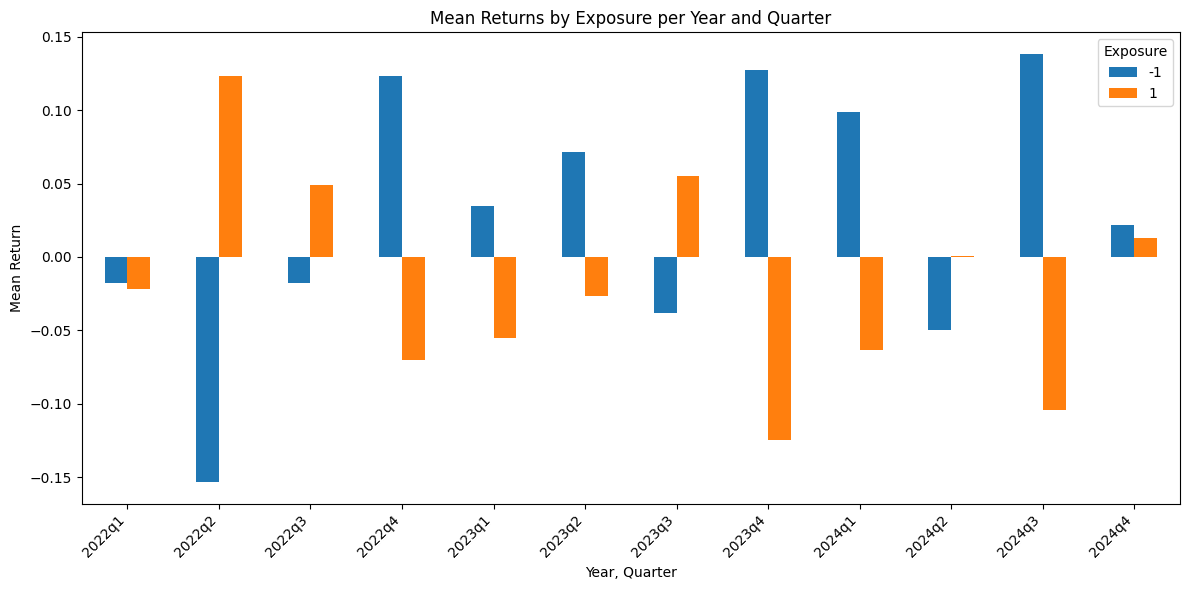

In [462]:
analysis['Year-Quarter'] = analysis["year"].astype(str) + "q" + analysis["quarter"].astype(str)

# Reset index for plotting
analysis.drop(["year","quarter"],axis=1,inplace=True)
analysis.reset_index(drop=True, inplace=True)

# Plot a bar chart
analysis.set_index("Year-Quarter").plot(
    kind="bar",
    figsize=(12, 6),
    title="Mean Returns by Exposure per Year and Quarter"
)

# Customize the plot
plt.xlabel("Year, Quarter")
plt.ylabel("Mean Return")
plt.xticks(rotation=45, ha='right')  # Rotate x-axis labels for better readability
plt.legend(title="Exposure")
plt.tight_layout()

# Show the plot
plt.show()


<Axes: title={'center': 'Mean Returns by Exposure per Year and Quarter'}, xlabel='Year-Quarter'>

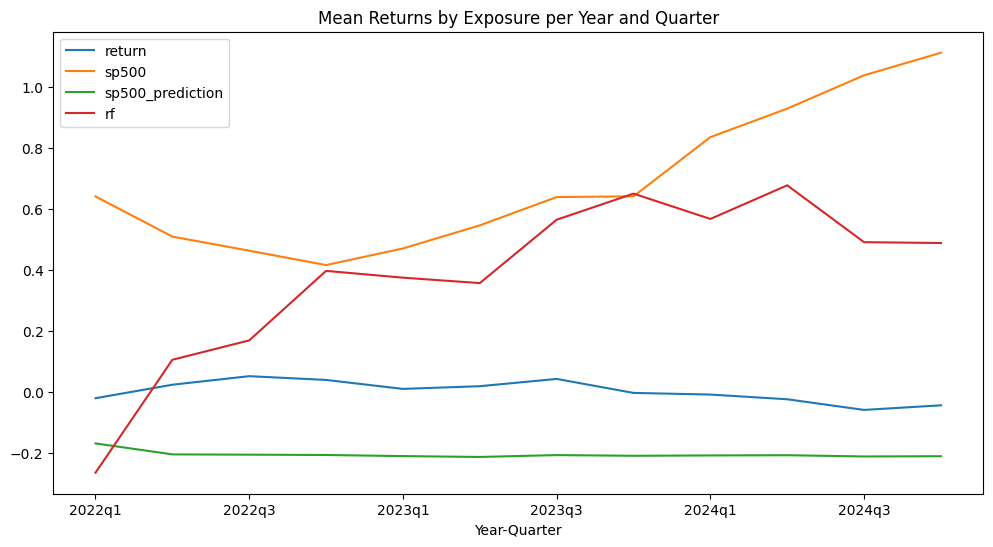

In [463]:
portfolio.drop(["year","quarter"],axis=1,inplace=True)
portfolio.set_index("Year-Quarter").plot(
    kind="line",
    figsize=(12, 6),
    title="Mean Returns by Exposure per Year and Quarter"
)

In [454]:
trades.groupby(["year","quarter","GICS Sector"]).agg({"return":"mean"}).tail(20)

return
year quarter GICS Sector                     
2024 3       Consumer Staples        0.054186
             Energy                  0.048160
             Financials              0.279983
             Health Care             0.099250
             Industrials             0.332781
             Information Technology  0.026552
             Materials               0.159470
             Real Estate             0.109009
             Utilities               0.183308
     4       Communication Services -0.016541
             Consumer Discretionary  0.036207
             Consumer Staples       -0.018719
             Energy                  0.055499
             Financials             -0.015555
             Health Care            -0.057079
             Industrials            -0.031548
             Information Technology -0.002348
             Materials               0.033875
             Real Estate            -0.003560
             Utilities              -0.020888

In [467]:
run = True
if run:
    analysises = []
    for direction in tqdm([1,-1]):
        for value in tqdm([1,0,-1]):
            for maximum_index in tqdm([1,50,100]):
                for minimum_index in [0,50,100]:
                    for num_stocks_per_industry in [1,5]:
                        try:
                            parameters = {
                                "direction":direction,
                                "val":value,
                                "maxi": maximum_index,
                                "mini": minimum_index,
                                "stacks": num_stocks_per_industry
                            }
                            stacks = rank_list(value,num_stocks_per_industry)
                            max_cap = simulation.sort_values("market_cap")["market_cap"].unique()[-maximum_index]
                            min_cap = simulation.sort_values("market_cap")["market_cap"].unique()[minimum_index]
                            filtered_simulation = simulation[(simulation["market_cap"]<=max_cap) & (simulation["market_cap"]>=min_cap)].copy()
                            trades = filtered_simulation[filtered_columns].groupby(["year","quarter","ticker"]).agg(agg_query).reset_index()
                            trades = trades.sort_values("rank",ascending=True).groupby(["year","quarter","GICS Sector"]).nth(stacks).reset_index()
                            trades["return"] = (trades["sell_price"] - trades["adjclose"])/trades["adjclose"]
                            trades["return"] = trades["return"] * trades["exposure"] * direction 
                            analysis = trades[["year","quarter","exposure","return"]].groupby(["year","quarter","exposure"]).mean().pivot_table(index=["year","quarter"],columns="exposure",values="return").reset_index()
                            portfolio = trades[["year","quarter","return"]].groupby(["year","quarter"]).mean().reset_index().sort_values(["year","quarter"])
                            portfolio["return"] = portfolio["return"] + 1
                            portfolio["return"] = portfolio["return"].cumprod() - 1
                            portfolio['Year-Quarter'] = portfolio["year"].astype(str) + "q" + portfolio["quarter"].astype(str)
                            portfolio = portfolio.merge(benchmark,on=["year","quarter"],how="left")
                            portfolio["sharpe"] = portfolio["return"] - portfolio["rf"] / portfolio["return"].std()
                            parameters["risk"] = portfolio["return"].std()
                            parameters["sharpe"] = portfolio["sharpe"].iloc[-1]
                            parameters["return"] = portfolio["return"].iloc[-1]
                            analysises.append(parameters)
                        except Exception as e:
                            print(str(e))
                            continue

  0%|                                                                                                                                                                    | 0/3 [00:00<?, ?it/s]

  0%|                                                                                                                                                                    | 0/3 [00:00<?, ?it/s]

 33%|████████████████████████████████████████████████████                                                                                                        | 1/3 [00:02<00:04,  2.21s/it]

 67%|████████████████████████████████████████████████████████████████████████████████████████████████████████                                                    | 2/3 [00:04<00:02,  2.16s/it]

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:06<00:00,  2.08s/it]

 33%|██████████████████████████████

In [468]:
a = pd.DataFrame(analysises)
a["color"] = ["blue" if x == 1 else "red" if x == -1  else "green" for x in a["val"]]
a["return_to_risk"] = a["return"] / a["risk"]
a.sort_values("return",ascending=False).head(50).dropna()

,direction,val,maxi,mini,stacks,risk,sharpe,return,color,return_to_risk
8,1,1,50,50,1,0.274519,-1.173399,0.604131,blue,2.200689
2,1,1,1,50,1,0.282134,-1.130275,0.599277,blue,2.124086
14,1,1,100,50,1,0.255445,-1.365985,0.544272,blue,2.130682
10,1,1,50,100,1,0.247861,-1.468691,0.500014,blue,2.017316
20,1,0,1,50,1,0.212632,-1.798055,0.496826,green,2.336553
16,1,1,100,100,1,0.245920,-1.489220,0.495023,blue,2.012938
0,1,1,1,0,1,0.240434,-1.566506,0.463014,blue,1.925741
4,1,1,1,100,1,0.238131,-1.608117,0.441033,blue,1.852065
6,1,1,50,0,1,0.218054,-1.810824,0.426998,blue,1.958224
18,1,0,1,0,1,0.185585,-2.215023,0.414311,green,2.232454


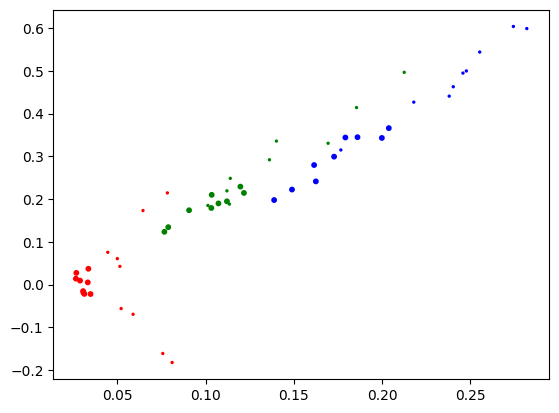

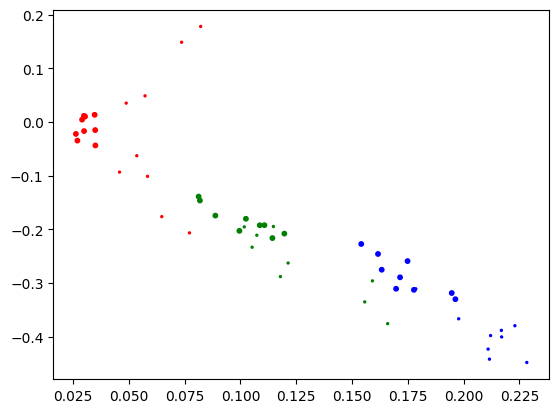

In [469]:
for direction in [1,-1]:
    d_analysis = a[a["direction"]== direction]
    plt.scatter(d_analysis["risk"],d_analysis["return"],c=d_analysis["color"],s=d_analysis["stacks"]*2)
    plt.show()

In [478]:
print(((macro["sp500"].pct_change().cumsum().iloc[-1]+1) ** (1/6))/macro["sp500"].pct_change().std())

87.22508174116743
